# Classification

## Deep Learning

### This notebook presents some tests on Classification, using some basic Fully Connected (Dense) Neural Networks.
### The dataset used in this example is the MNIST, which is included within Keras.

#### This notebook requires Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras import backend as B
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from time import time
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

random.seed(13)

## Data Exploration

Let's load the MNIST dataset from Keras into two separate sets:
* A training set
* A validation set

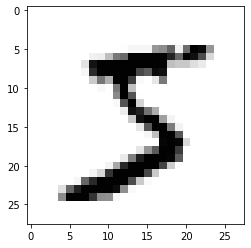

In [3]:
# Load MNIST database
(X_train,y_train), (X_val,y_val) = mnist.load_data()

# Print a train pattern
plt.imshow(X_train[0], cmap='Greys')

# Rescale pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Labels --> one-hot encodings
y_train = to_categorical(y_train.reshape([-1, 1]))
y_val = to_categorical(y_val.reshape([-1, 1]))

Let's print a histogram of the counts of the distinct digits in MNIST

Text(0.5, 1.0, 'Labels in MNIST dataset')

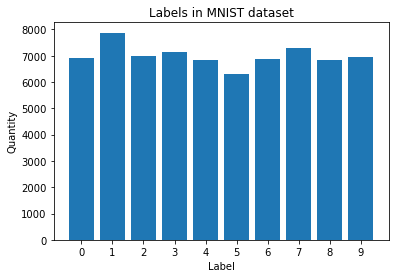

In [4]:
y_l = np.array([np.where(r==1)[0][0] for r in np.concatenate((y_train, y_val))])
unique, counts = np.unique(y_l, return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.title("Labels in MNIST dataset")

We can see that the counts of different lables (digits) are about the same.

5 has the lowest count while 2 has the highest one.

## Experimentation

Now we define a function through which we will build the Neural Network Model.

This function creates a fully connected (dense) neural network for multi-class classification.

We use the <b>categorical_crossentropy</b> loss function and we measure the <b>accuracy</b> of the model.

In [5]:
def build_model(X, y, activation=relu, layers=5, units=32, learning_rate=0.01):
    """
    Build a Neural Network model based on the data and the parameters
    """
    # Neural network parameters
    input_shape = X.shape[1:]
    output_units = y.shape[1]
    
    # Model creation
    model = Sequential()
    model.add(Input(input_shape)) # Input layer
    model.add(Flatten()) # Flatten input (transform it into 1D array)
    for i in range(layers):
        model.add(Dense(units, activation=activation)) # Intermediate layers
    model.add(Dense(output_units, activation=softmax)) # Output layer

    # Model training
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

Now we define two functions:
* A function to retrieve the neuron gradients
* A function to retrieve the neuron biases

In [6]:
def get_weight_gradients(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights """
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = B.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    if sample_weight is None:
        sample_weight = []
    output_grad = f(x + y + sample_weight)
    return np.array(output_grad, dtype=object)

def get_layer_output_gradients(model, inputs, outputs, layer=-1):
    """ Gets gradient of a layer output for given inputs and outputs """
    grads = model.optimizer.get_gradients(model.total_loss, model.layers[layer].output)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = B.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    if sample_weight is None:
        sample_weight = []
    output_grad = f(x + y + sample_weight)
    return np.array(output_grad, dtype=object)

Let's select randomly a continuous mini batch of zize 32 from the training samples, in order to use it layer for printing the gradients and biases.

In [7]:
batch_size = 32
batches = int(X_train.shape[0] / batch_size)
batch = random.randint(0, batches - 1)
batch_start = batch * batch_size
batch_end = batch_start + batch_size

We initialize 5 distinct dictionaries to store the measurements which will be used for the model evaluation and comparisons.

In [8]:
# Initialize lists for data storage
times = {'relu': [], 'tanh': [], 'sigmoid': []}
accuracies = {'relu': [], 'tanh': [], 'sigmoid': []}
precisions = {'relu': [], 'tanh': [], 'sigmoid': []}
recalls = {'relu': [], 'tanh': [], 'sigmoid': []}
f1s = {'relu': [], 'tanh': [], 'sigmoid': []}

We want to compare the outcome of multi-class classification using the following 3 activation functions:
* Rectified Linear Unit (ReLU)
* Hyperbolic tangent (tanh)
* Logistic (sigmoid)


We also distinguish 3 distinct numbers of intermediate layers:
* 5
* 20
* 40

### Case (i): 5 intermediate layers

In [9]:
# Number of intermediate layers
intermediate_layers = 5

# Number of units per intermediate layer
units = 32

# Learning rate
learning_rate = 0.01

# Epochs
epochs = 10

# Empty gradients and biases
gradients = {'relu': [], 'tanh': [], 'sigmoid': []}
biases = {'relu': [], 'tanh': [], 'sigmoid': []}

#### Subcase (i)-(a): ReLU

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                3

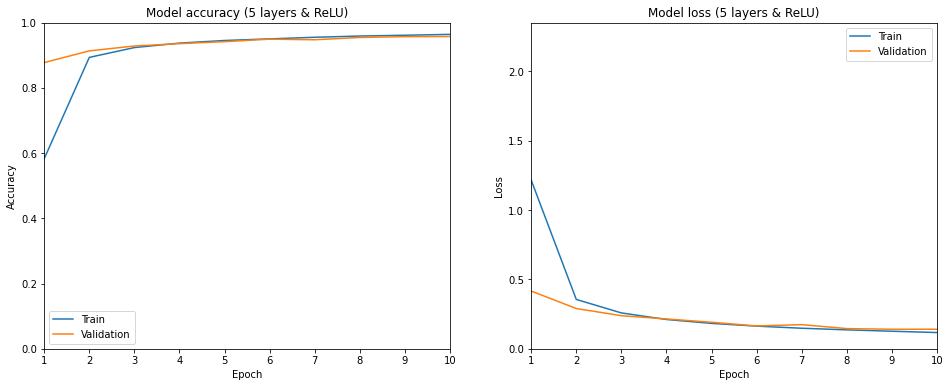

Time (sec): 71.94785332679749
Accuracy: 0.9519
Precision: 0.9580845136744006
Recall: 0.9653688512584022
F1 score: 0.9514302637928245


In [10]:
activation = relu

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['relu'].append(weights)
biases['relu'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./relu-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['relu'].append(weights)
biases['relu'].append(bias)
times['relu'].append(t)
accuracies['relu'].append(acc)
precisions['relu'].append(prec)
recalls['relu'].append(rec)
f1s['relu'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (i)-(b): Hyperbolic tangent - tanh

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

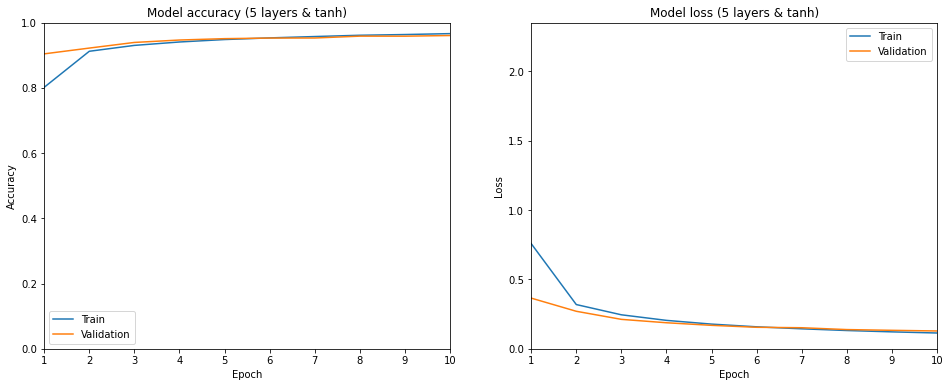

Time (sec): 111.04888677597046
Accuracy: 0.9552
Precision: 0.9608991450159063
Recall: 0.9673665383518086
F1 score: 0.9547634342357341


In [11]:
activation = tanh

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['tanh'].append(weights)
biases['tanh'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./tanh-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['tanh'].append(weights)
biases['tanh'].append(bias)
times['tanh'].append(t)
accuracies['tanh'].append(acc)
precisions['tanh'].append(prec)
recalls['tanh'].append(rec)
f1s['tanh'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (i)-(c): Sigmoid

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 10)               

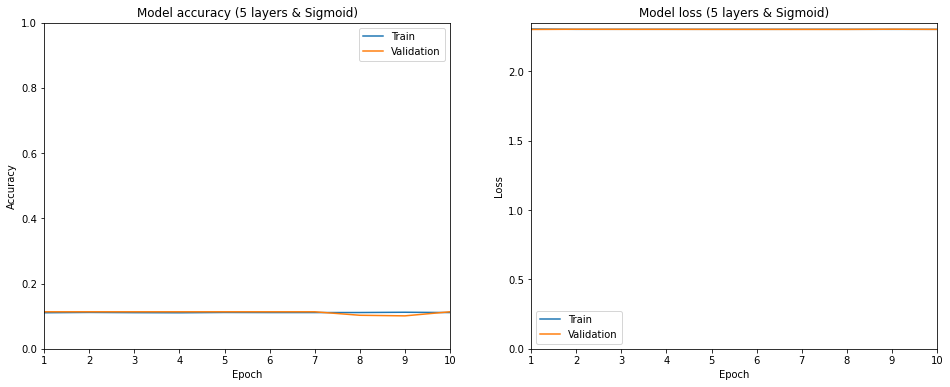

Time (sec): 152.7086262702942
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [12]:
activation = sigmoid

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./sigmoid-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)
times['sigmoid'].append(t)
accuracies['sigmoid'].append(acc)
precisions['sigmoid'].append(prec)
recalls['sigmoid'].append(rec)
f1s['sigmoid'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Let's plot the gradients and biases to monitor the changes between the untrained model and the trained one.

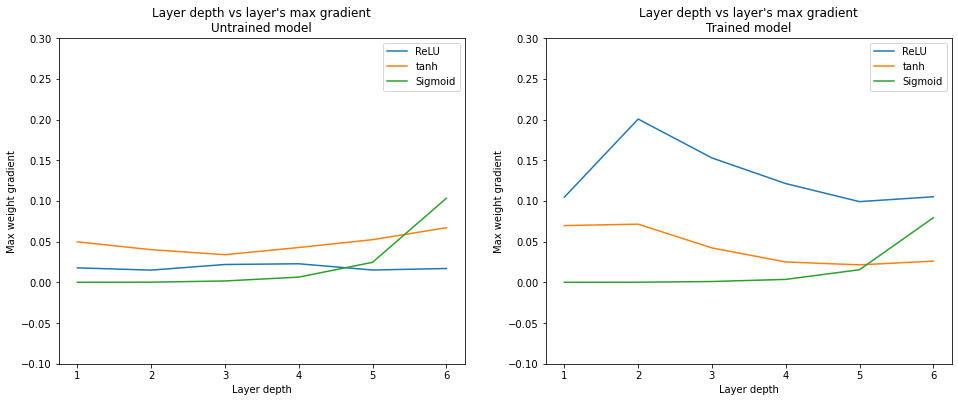

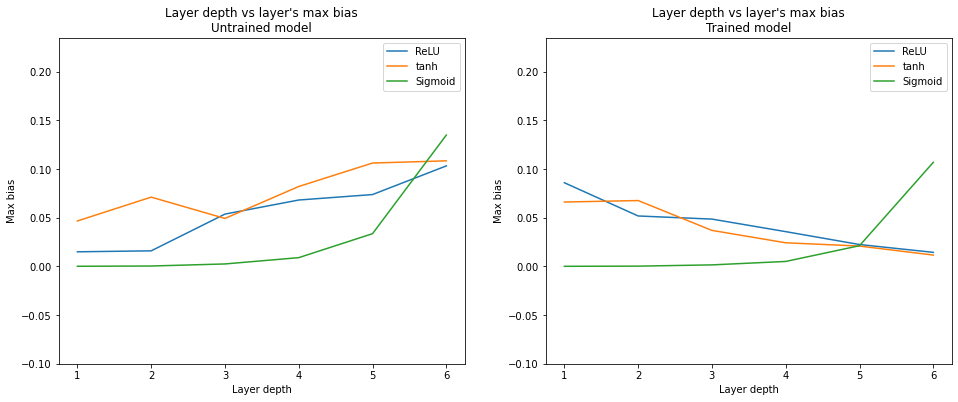

In [13]:
ylim = max([max(gradients['relu'][0]), max(gradients['relu'][1]), \
           max(gradients['tanh'][0]), max(gradients['tanh'][1]), \
           max(gradients['sigmoid'][0]), max(gradients['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,1))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][0])+1),gradients['relu'][0])
plt.plot(range(1,len(gradients['tanh'][0])+1),gradients['tanh'][0])
plt.plot(range(1,len(gradients['sigmoid'][0])+1),gradients['sigmoid'][0])
plt.title("Layer depth vs layer's max gradient\nUntrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,1))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][1])+1),gradients['relu'][1])
plt.plot(range(1,len(gradients['tanh'][1])+1),gradients['tanh'][1])
plt.plot(range(1,len(gradients['sigmoid'][1])+1),gradients['sigmoid'][1])
plt.title("Layer depth vs layer's max gradient\nTrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./gradients-{intermediate_layers}.png')


ylim = max([max(biases['relu'][0]), max(biases['relu'][1]), \
           max(biases['tanh'][0]), max(biases['tanh'][1]), \
           max(biases['sigmoid'][0]), max(biases['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,1))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][0])+1),biases['relu'][0])
plt.plot(range(1,len(biases['tanh'][0])+1),biases['tanh'][0])
plt.plot(range(1,len(biases['sigmoid'][0])+1),biases['sigmoid'][0])
plt.title("Layer depth vs layer's max bias\nUntrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,1))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][1])+1),biases['relu'][1])
plt.plot(range(1,len(biases['tanh'][1])+1),biases['tanh'][1])
plt.plot(range(1,len(biases['sigmoid'][1])+1),biases['sigmoid'][1])
plt.title("Layer depth vs layer's max bias\nTrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./biases-{intermediate_layers}.png')

### Case (ii): 20 intermediate layers

In [14]:
# Number of intermediate layers
intermediate_layers = 20

# Number of units per intermediate layer
units = 32

# Learning rate
lr = 0.01

# Epochs
epochs = 10

# Empty gradients and biases
gradients = {'relu': [], 'tanh': [], 'sigmoid': []}
biases = {'relu': [], 'tanh': [], 'sigmoid': []}

#### Subcase (ii)-(a): ReLU

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 32)               

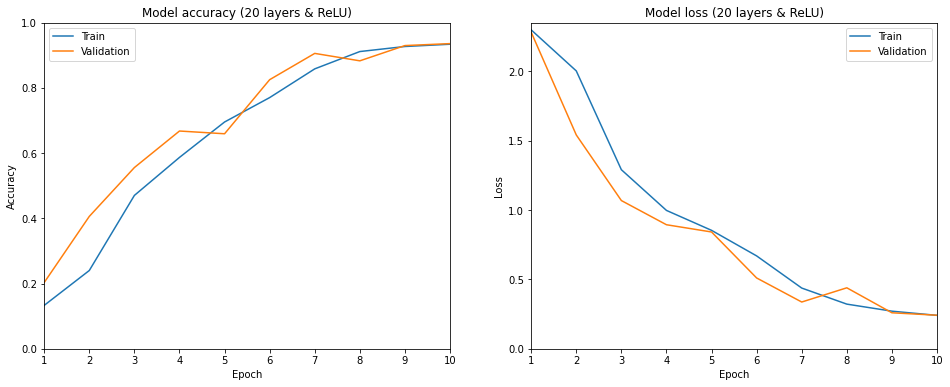

Time (sec): 129.353253364563
Accuracy: 0.9232
Precision: 0.9377960625537085
Recall: 0.9550348356157041
F1 score: 0.9224441295979675


In [15]:
activation = relu

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['relu'].append(weights)
biases['relu'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./relu-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['relu'].append(weights)
biases['relu'].append(bias)
times['relu'].append(t)
accuracies['relu'].append(acc)
precisions['relu'].append(prec)
recalls['relu'].append(rec)
f1s['relu'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (ii)-(b): Hyperbolic tangent - tanh

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_44 (Dense)             (None, 32)               

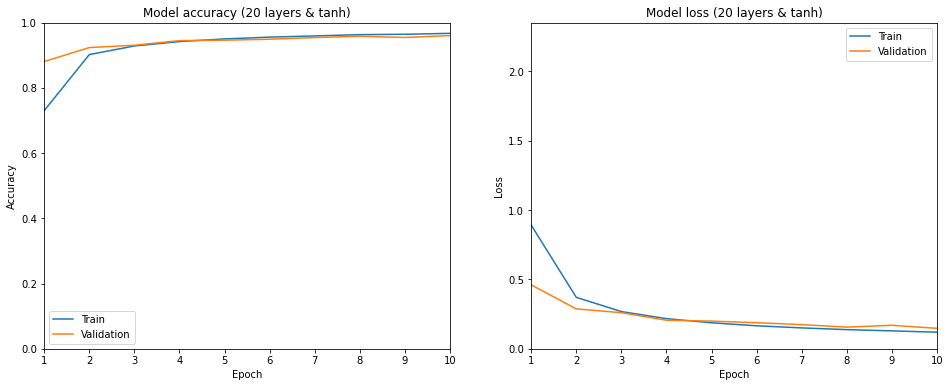

Time (sec): 143.38407397270203
Accuracy: 0.955
Precision: 0.9595412235557104
Recall: 0.9647176691802187
F1 score: 0.954548554735724


In [16]:
activation = tanh

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['tanh'].append(weights)
biases['tanh'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./tanh-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['tanh'].append(weights)
biases['tanh'].append(bias)
times['tanh'].append(t)
accuracies['tanh'].append(acc)
precisions['tanh'].append(prec)
recalls['tanh'].append(rec)
f1s['tanh'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (ii)-(c): Sigmoid

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_63 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_64 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_65 (Dense)             (None, 32)               

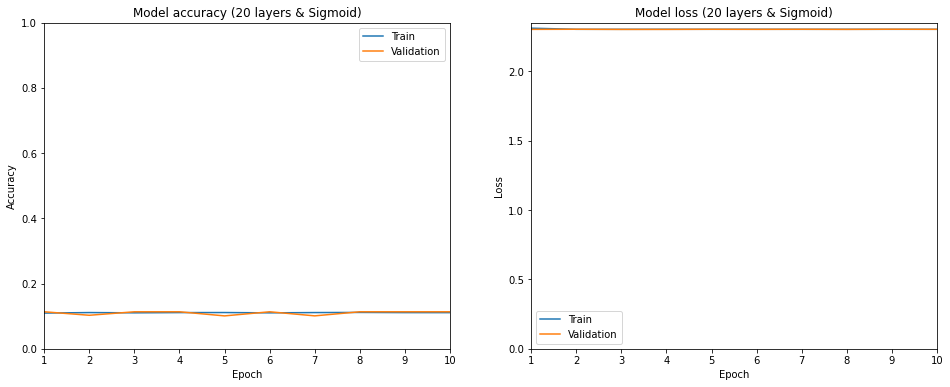

Time (sec): 192.42138147354126
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [17]:
activation = sigmoid

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./sigmoid-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)
times['sigmoid'].append(t)
accuracies['sigmoid'].append(acc)
precisions['sigmoid'].append(prec)
recalls['sigmoid'].append(rec)
f1s['sigmoid'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Let's plot the gradients and biases to monitor the changes between the untrained model and the trained one.

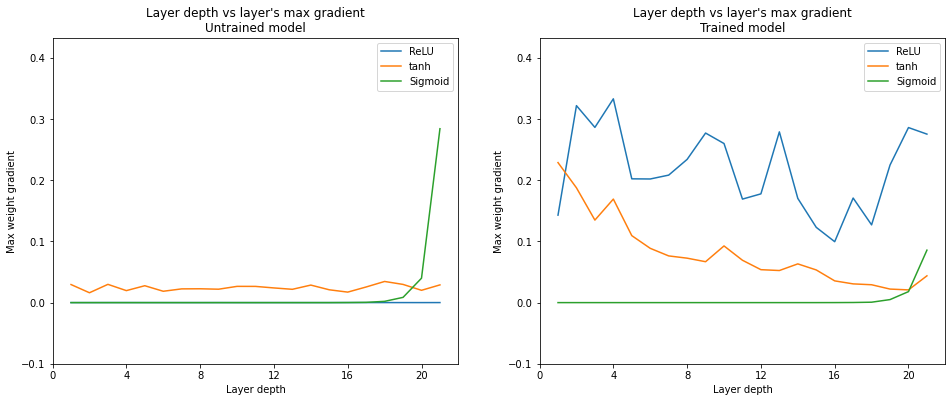

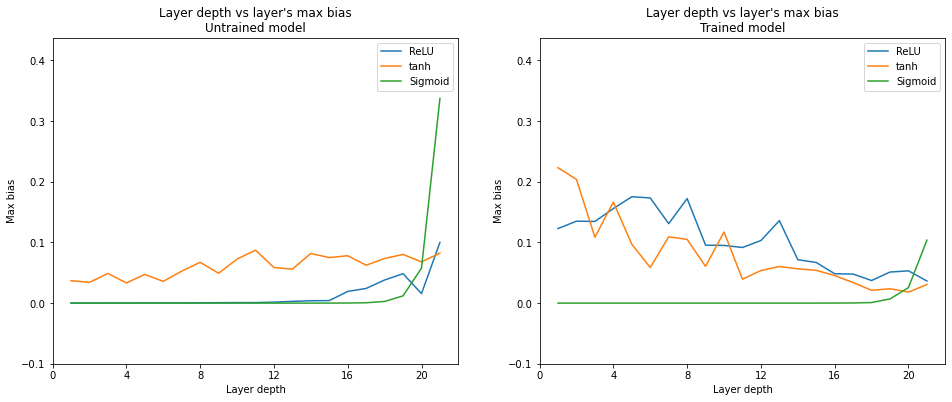

In [18]:
ylim = max([max(gradients['relu'][0]), max(gradients['relu'][1]), \
           max(gradients['tanh'][0]), max(gradients['tanh'][1]), \
           max(gradients['sigmoid'][0]), max(gradients['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,4))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][0])+1),gradients['relu'][0])
plt.plot(range(1,len(gradients['tanh'][0])+1),gradients['tanh'][0])
plt.plot(range(1,len(gradients['sigmoid'][0])+1),gradients['sigmoid'][0])
plt.title("Layer depth vs layer's max gradient\nUntrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,4))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][1])+1),gradients['relu'][1])
plt.plot(range(1,len(gradients['tanh'][1])+1),gradients['tanh'][1])
plt.plot(range(1,len(gradients['sigmoid'][1])+1),gradients['sigmoid'][1])
plt.title("Layer depth vs layer's max gradient\nTrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./gradients-{intermediate_layers}.png')


ylim = max([max(biases['relu'][0]), max(biases['relu'][1]), \
           max(biases['tanh'][0]), max(biases['tanh'][1]), \
           max(biases['sigmoid'][0]), max(biases['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,4))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][0])+1),biases['relu'][0])
plt.plot(range(1,len(biases['tanh'][0])+1),biases['tanh'][0])
plt.plot(range(1,len(biases['sigmoid'][0])+1),biases['sigmoid'][0])
plt.title("Layer depth vs layer's max bias\nUntrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,4))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][1])+1),biases['relu'][1])
plt.plot(range(1,len(biases['tanh'][1])+1),biases['tanh'][1])
plt.plot(range(1,len(biases['sigmoid'][1])+1),biases['sigmoid'][1])
plt.title("Layer depth vs layer's max bias\nTrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./biases-{intermediate_layers}.png')

### Case (iii): 40 intermediate layers

In [19]:
# Number of intermediate layers
intermediate_layers = 40

# Number of units per intermediate layer
units = 32

# Learning rate
lr = 0.01

# Epochs
epochs = 10

# Empty gradients and biases
gradients = {'relu': [], 'tanh': [], 'sigmoid': []}
biases = {'relu': [], 'tanh': [], 'sigmoid': []}

#### Subcase (iii)-(a): ReLU

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_82 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_84 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_85 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_86 (Dense)             (None, 32)               

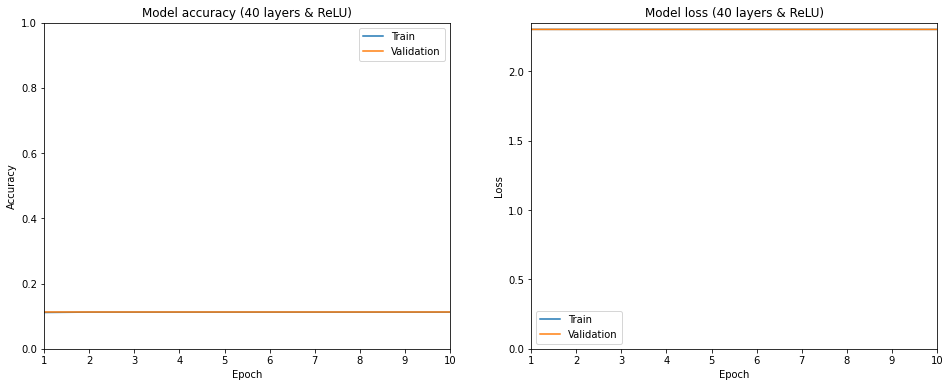

Time (sec): 197.20036578178406
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [20]:
activation = relu

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['relu'].append(weights)
biases['relu'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & ReLU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./relu-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['relu'].append(weights)
biases['relu'].append(bias)
times['relu'].append(t)
accuracies['relu'].append(acc)
precisions['relu'].append(prec)
recalls['relu'].append(rec)
f1s['relu'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (iii)-(b): Hyperbolic tangent - tanh

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_123 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_125 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_126 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_127 (Dense)            (None, 32)               

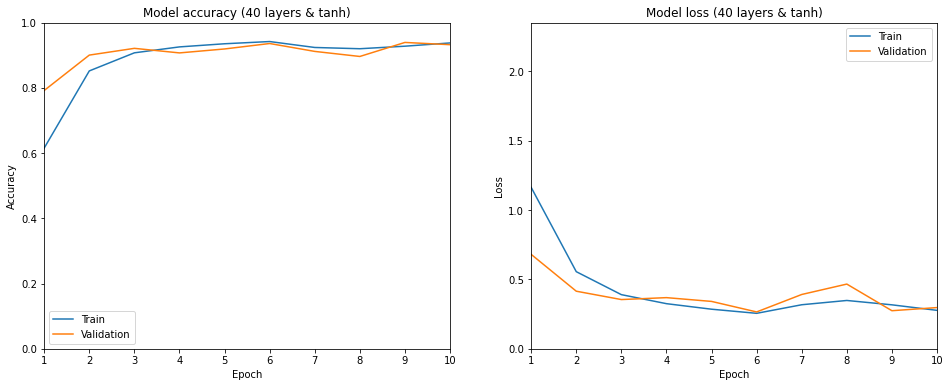

Time (sec): 246.55409145355225
Accuracy: 0.9259
Precision: 0.933692674908098
Recall: 0.9432663205479497
F1 score: 0.9252249153412327


In [21]:
activation = tanh

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['tanh'].append(weights)
biases['tanh'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & tanh)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./tanh-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['tanh'].append(weights)
biases['tanh'].append(bias)
times['tanh'].append(t)
accuracies['tanh'].append(acc)
precisions['tanh'].append(prec)
recalls['tanh'].append(rec)
f1s['tanh'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

#### Subcase (iii)-(c): Sigmoid

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_164 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_165 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_166 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_167 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_168 (Dense)            (None, 32)               

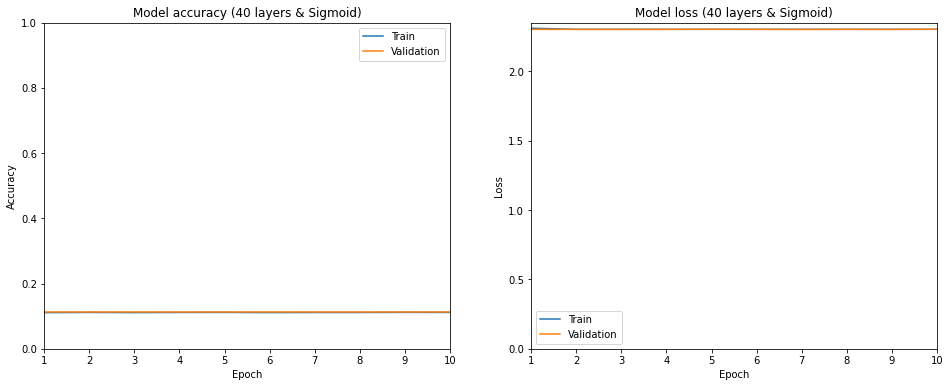

Time (sec): 224.5332236289978
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [22]:
activation = sigmoid

model = build_model(X_train, y_train, activation, intermediate_layers, units, learning_rate)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))
gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)

t = time()
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))
t = time() - t

fig = plt.figure(figsize=(16,6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1),history.history['accuracy'])
plt.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.title('Model accuracy (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1),history.history['loss'])
plt.plot(range(1,epochs+1),history.history['val_loss'])
plt.title('Model loss (' + str(intermediate_layers) +' layers & Sigmoid)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., 2.35)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig(f'./sigmoid-{intermediate_layers}.png')

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, prec, rec, f1 = accuracy_score(y_val, y_val_pred_cat), \
                    f1_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    precision_score(y_val, y_val_pred_cat, average='macro', zero_division=0), \
                    recall_score(y_val, y_val_pred_cat, average='macro', zero_division=0)

grads = get_weight_gradients(model, X_train[batch_start:batch_end], y_train[batch_start:batch_end])
weights = []
bias = []
for grad in grads:
    if len(grad.shape) == 2:
        weights.append(np.max(grad))
    else:
        bias.append(np.max(grad))

gradients['sigmoid'].append(weights)
biases['sigmoid'].append(bias)
times['sigmoid'].append(t)
accuracies['sigmoid'].append(acc)
precisions['sigmoid'].append(prec)
recalls['sigmoid'].append(rec)
f1s['sigmoid'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Let's plot the gradients and biases to monitor the changes between the untrained model and the trained one.

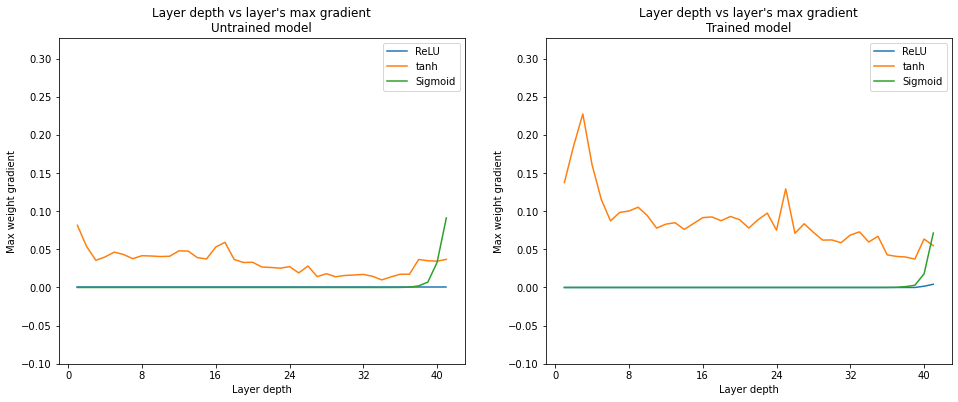

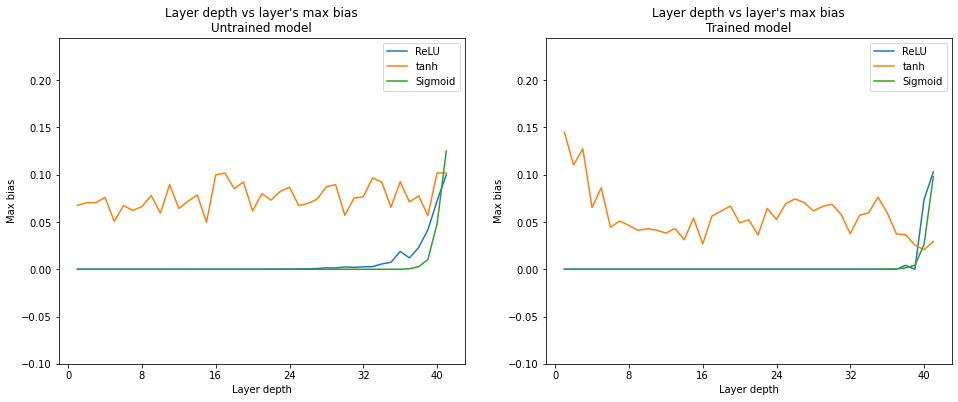

In [23]:
ylim = max([max(gradients['relu'][0]), max(gradients['relu'][1]), \
           max(gradients['tanh'][0]), max(gradients['tanh'][1]), \
           max(gradients['sigmoid'][0]), max(gradients['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,8))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][0])+1),gradients['relu'][0])
plt.plot(range(1,len(gradients['tanh'][0])+1),gradients['tanh'][0])
plt.plot(range(1,len(gradients['sigmoid'][0])+1),gradients['sigmoid'][0])
plt.title("Layer depth vs layer's max gradient\nUntrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,8))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(gradients['relu'][1])+1),gradients['relu'][1])
plt.plot(range(1,len(gradients['tanh'][1])+1),gradients['tanh'][1])
plt.plot(range(1,len(gradients['sigmoid'][1])+1),gradients['sigmoid'][1])
plt.title("Layer depth vs layer's max gradient\nTrained model")
plt.ylabel('Max weight gradient')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./gradients-{intermediate_layers}.png')


ylim = max([max(biases['relu'][0]), max(biases['relu'][1]), \
           max(biases['tanh'][0]), max(biases['tanh'][1]), \
           max(biases['sigmoid'][0]), max(biases['sigmoid'][1])])

fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.xticks(range(0,intermediate_layers+2,8))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][0])+1),biases['relu'][0])
plt.plot(range(1,len(biases['tanh'][0])+1),biases['tanh'][0])
plt.plot(range(1,len(biases['sigmoid'][0])+1),biases['sigmoid'][0])
plt.title("Layer depth vs layer's max bias\nUntrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.xticks(range(0,intermediate_layers+2,8))
plt.ylim(-0.1,ylim+0.1)
plt.plot(range(1,len(biases['relu'][1])+1),biases['relu'][1])
plt.plot(range(1,len(biases['tanh'][1])+1),biases['tanh'][1])
plt.plot(range(1,len(biases['sigmoid'][1])+1),biases['sigmoid'][1])
plt.title("Layer depth vs layer's max bias\nTrained model")
plt.ylabel('Max bias')
plt.xlabel('Layer depth')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig('./biases-{intermediate_layers}.png')

### Results

Let's plot the results and compare the performance of the models.

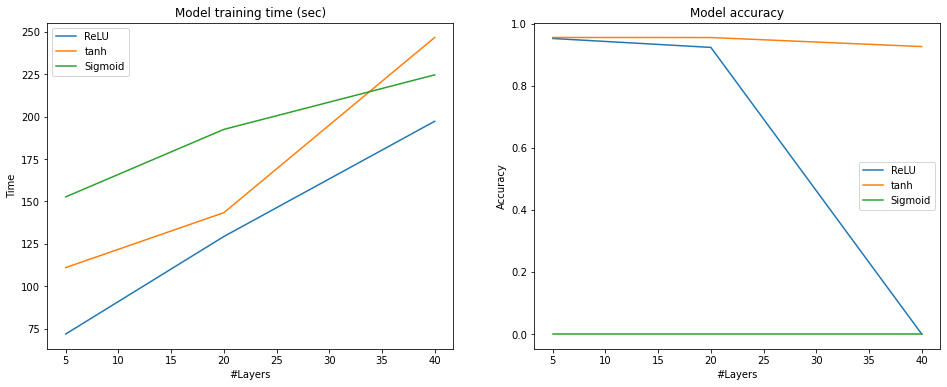

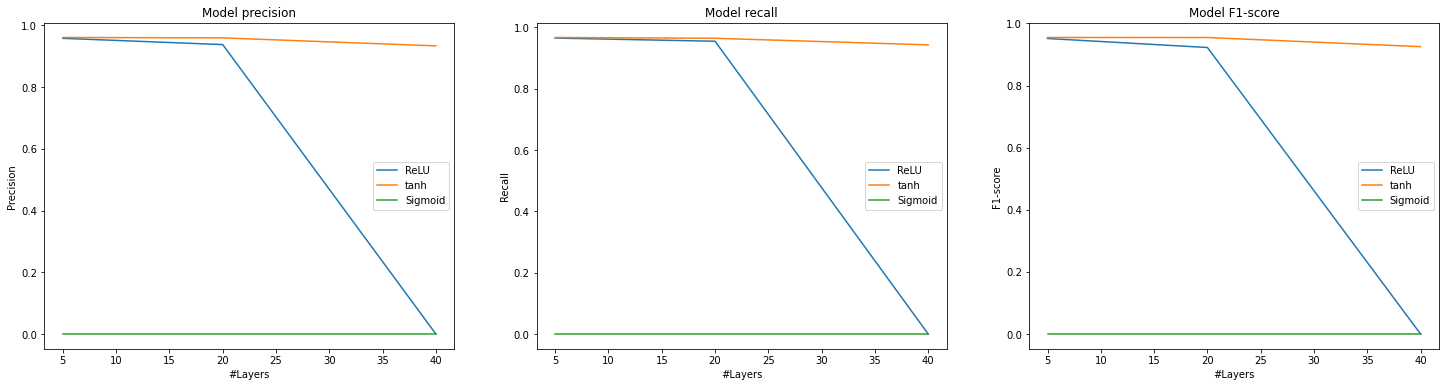

In [24]:
fig = plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot([5,20,40],times['relu'])
plt.plot([5,20,40],times['tanh'])
plt.plot([5,20,40],times['sigmoid'])
plt.title('Model training time (sec)')
plt.ylabel('Time')
plt.xlabel('#Layers')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 2, 2)
plt.plot([5,20,40],accuracies['relu'])
plt.plot([5,20,40],accuracies['tanh'])
plt.plot([5,20,40],accuracies['sigmoid'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('#Layers')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig(f'./measurements-1.png')


fig = plt.figure(figsize=(25,6))

plt.subplot(1, 3, 1)
plt.plot([5,20,40],precisions['relu'])
plt.plot([5,20,40],precisions['tanh'])
plt.plot([5,20,40],precisions['sigmoid'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('#Layers')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 3, 2)
plt.plot([5,20,40],recalls['relu'])
plt.plot([5,20,40],recalls['tanh'])
plt.plot([5,20,40],recalls['sigmoid'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('#Layers')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.subplot(1, 3, 3)
plt.plot([5,20,40],f1s['relu'])
plt.plot([5,20,40],f1s['tanh'])
plt.plot([5,20,40],f1s['sigmoid'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('#Layers')
plt.legend(['ReLU', 'tanh', 'Sigmoid'], loc='best')

plt.show()
# fig.savefig(f'./measurements-2.png')